In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

def load_data(folder_path):
    images = []
    labels = []
    for category in os.listdir(folder_path):
        category_folder = os.path.join(folder_path, category)
        if not os.path.isdir(category_folder):
            continue  # Skip if it's not a directory

        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            try:
                image = load_img(image_path, target_size=(128, 128))  # Resize
                image_array = img_to_array(image)
                images.append(image_array)
                labels.append(category)  # Assuming folder name is label
            except Exception as e:
                print(f"Skipping file {image_path}: {e}")
    
    return images, labels

folder_path = "/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new"
images, labels = load_data(folder_path)

In [ ]:
len(images)

In [ ]:
images=np.array(images)
labels=np.array(labels)

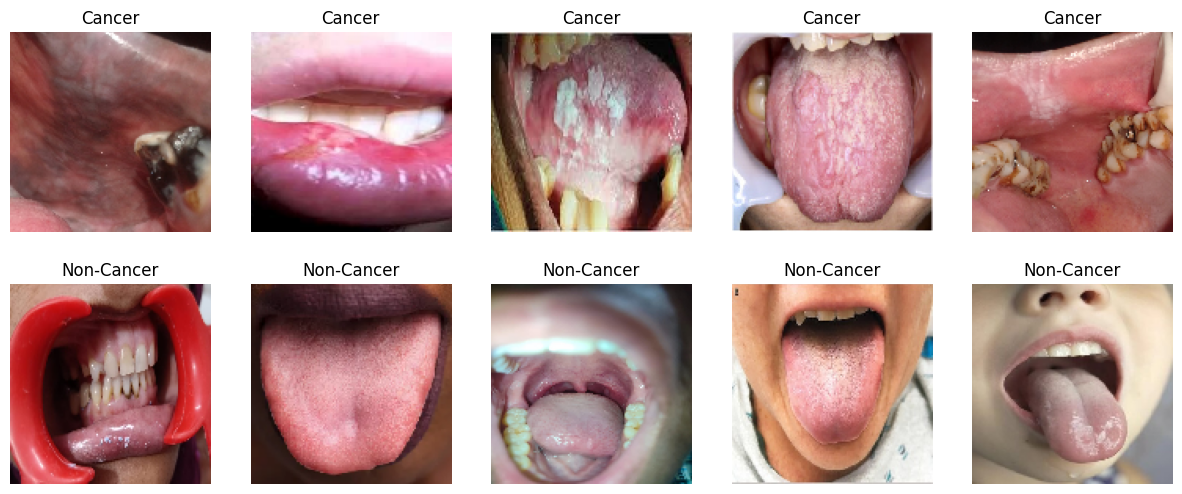

In [24]:
import matplotlib.pyplot as plt
import numpy as np

cancer_images = images[labels == 'CANCER'][:5]  
non_cancer_images = images[labels == 'NON CANCER'][:5]  

# Merge for plotting
sample_images = np.concatenate([cancer_images, non_cancer_images])
sample_labels = ["Cancer"] * 5 + ["Non-Cancer"] * 5  

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i].astype(np.uint8))  
    ax.set_title(sample_labels[i])  
    ax.axis('off')  

plt.show()



In [25]:
print(np.unique(labels, return_counts=True))  


(array(['CANCER', 'NON CANCER'], dtype='<U10'), array([490, 450]))


In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
binary_labels = encoder.fit_transform(labels)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, binary_labels, test_size=0.2, random_state=42, shuffle=True)

# Define and compile the model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

# Train the model
history = model.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6540 - loss: 9.3512 - precision: 0.6309 - recall: 0.6616
Epoch 1: val_accuracy improved from -inf to 0.45745, saving model to /kaggle/working/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 557ms/step - accuracy: 0.6545 - loss: 9.3714 - precision: 0.6316 - recall: 0.6619 - val_accuracy: 0.4574 - val_loss: 531.8815 - val_precision: 0.4574 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7410 - loss: 7.7531 - precision: 0.7489 - recall: 0.7206
Epoch 2: val_accuracy improved from 0.45745 to 0.50532, saving model to /kaggle/working/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.7402 - loss: 7.7295 - precision: 0.7471 - recall: 0.7201 - val_accuracy: 0.5053 - val_loss: 32.2549 - val_precision: 0.4783 - val_recall: 0.8953 - learning_rate: 0.0010
Epoch 3/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7834 - loss: 5.8611 - precision: 0

In [31]:
model.save('/kaggle/working/new_oral_best_model.keras')
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/new_oral_best_model.keras')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
tflite_model_path = "/kaggle/working/new_oral_best_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")


Saved artifact at '/tmp/tmpbfklhwx8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139744158602816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744158603168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744428365376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744428371712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744418858256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744418861776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744418860720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744418857200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744418864416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139744418859312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397444188589

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt


In [11]:
images = images.astype('float32') / 255.0

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, binary_labels, test_size=0.2, random_state=42, stratify=binary_labels)

# Reshape labels for binary classification
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [12]:
# Load InceptionResNetV2 without top layers (pre-trained on ImageNet)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers to use pre-trained features
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 55,124,193 (210.28 MB)

 Trainable params: 787,457 (3.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust based on results
    batch_size=16,  # Adjust based on memory
    verbose=1
)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.6227 - loss: 1.0242 - val_accuracy: 0.8670 - val_loss: 0.4281
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8033 - loss: 0.6071 - val_accuracy: 0.8723 - val_loss: 0.3613
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8285 - loss: 0.4519 - val_accuracy: 0.8936 - val_loss: 0.3048
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8893 - loss: 0.2921 - val_accuracy: 0.8883 - val_loss: 0.2585
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8820 - loss: 0.2511 - val_accuracy: 0.8989 - val_loss: 0.2367
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8986 - loss: 0.2530 - val_accuracy: 0.9043 - val_loss: 0.2660
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9008 - loss: 0.2217 - val_accuracy: 0.9149 - val_loss: 0.2536
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9241 - loss: 0.1746 - val_accuracy: 0.8883 -

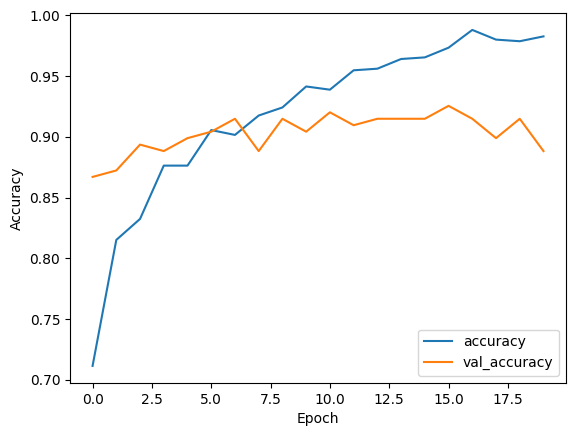

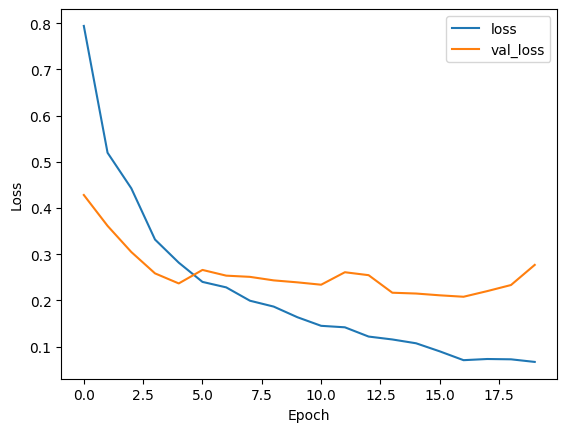

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [15]:
model.save('oral_cancer_detection_inception_rescnet_v2.h5')

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import load_model

# Register InceptionResNetV2 to avoid unknown layer issues
custom_objects = {'InceptionResNetV2': InceptionResNetV2}

# Load the saved model with custom objects
model = load_model('/kaggle/working/oral_cancer_detection_inception_rescnet_v2.h5', 
                   custom_objects=custom_objects)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
tflite_model_path = "/kaggle/working/oral_cancer_detection.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite!")


ValueError: Unknown layer: 'CustomScaleLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [19]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load data
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(128, 128))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0"
images, labels = load_data(folder_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Define and compile the model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

# Train the model
history = model.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/cancer'